In [1]:
import os
os.chdir('../..')
!ls

product_impacts


In [2]:
import os.path
import pandas as pd
from skimpy import skim
import requests
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, mean_squared_error, r2_score, roc_auc_score, balanced_accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from hiclass import LocalClassifierPerParentNode, LocalClassifierPerLevel

from product_impacts.product_cat.run_model import get_store, get_ndns_cats, get_products, get_ndns_matches, get_tsne

import numpy as np
import pickle
import json

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

sns.set()

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.environ["RAY_ENABLE_MAC_LARGE_OBJECT_STORE"] = "1"

In [5]:
ndns = get_ndns_cats('../../future_of_food/NDNS UK/ndns_edited.csv')
products = get_products('../../future_of_food/foodDB_23June/products.csv')
labelled_data, non_food_products = get_ndns_matches(
    ndns, products)

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
# removing duplicated product names + ingredients (basically products with same exact feature vectors)
labelled_data['product_list_name_lower'] = labelled_data['product_list_name'].str.lower()
labelled_data['ingredients_text_lower'] = labelled_data['ingredients_text'].str.lower()
labelled_data = labelled_data.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [7]:
# lev 0 predictions
predicted_data = pd.read_csv('../../future_of_food/NDNS UK/predictions/predictions_lev0_manuallabels_nonHI_RF_withcorrections_14Oct2024.csv')

In [8]:
predicted_data.shape

(262711, 11)

In [9]:
predicted_data['parentcategory_pred'].value_counts()

Cereals and Cereal Products             52426
Miscellaneous                           27598
Meat and Meat Products                  26837
Non-Alcoholic Beverages                 25994
Sugar, Preserves and Confectionery      25822
Vegetables, Potatoes                    23757
Milk and Milk Products                  23239
Alcoholic Beverages                     15150
Fish and Fish Dishes                     9302
Fruit                                    7343
Savoury Snacks                           6453
Not Food                                 5086
Nuts and Seeds                           5057
Fat Spreads                              3811
Commercial Toddlers Foods and Drinks     2488
Eggs and Egg Dishes                      1315
Dietary Supplements                       622
Artificial Sweeteners                     404
Savoury Snack                               7
Name: parentcategory_pred, dtype: int64

In [10]:
cereals_pred = predicted_data[predicted_data['parentcategory_pred']=='Cereals and Cereal Products'].reset_index(drop=True)
cereals_lab = labelled_data[(labelled_data['parentcategory']=='Cereals and Cereal Products')
                           & (labelled_data['subfoodgroupdesc'].notnull())].reset_index(drop=True)
cereals_lab = cereals_lab.merge(cereals_pred[['product_id']])

In [11]:
cereals_pred.shape

(52426, 11)

In [12]:
cereals_lab.shape

(11324, 12)

In [13]:
cereals_lab['subfoodgroupdesc'].value_counts()

Biscuits                                             2795
Pasta                                                1598
Buns cakes and pastries                              1289
Pizza                                                1096
High fibre breakfast cereals                         1007
Rice                                                  521
Other cereals                                         491
White bread (not high fibre, not multiseed bread)     486
Other breakfast cereals (not high fibre)              450
Other cereal based puddings                           446
Other bread                                           393
Wholemeal bread                                       282
Sponge puddings                                       153
Cereal based milk puddings                            130
Brown, granary and wheatgerm bread                    107
Fruit pies                                             80
Name: subfoodgroupdesc, dtype: int64

In [14]:
cereals_lab['mainfoodgroupdesc'].value_counts()

Pasta, rice and other miscellaneous cereals    3706
Biscuits                                       2795
Breakfast cereals                              1457
Buns, cakes, pastries and fruit pies           1369
Bread                                          1268
Puddings                                        729
Name: mainfoodgroupdesc, dtype: int64

In [15]:
cereals_pred['subfoodgroup_lab'].value_counts()

Biscuits                                                      2762
Pasta                                                         1598
Buns cakes and pastries                                       1285
Pizza                                                         1096
High fibre breakfast cereals                                  1007
Rice                                                           521
White bread (not high fibre, not multiseed bread)              486
Other cereals                                                  475
Other breakfast cereals (not high fibre)                       450
Other bread                                                    393
Wholemeal bread                                                282
Other cereal based puddings                                    255
Sponge puddings                                                153
Cereal based milk puddings                                     130
Brown, granary and wheatgerm bread                            

In [16]:
lev2_labels_add = cereals_pred[[
    'product_id', 'product_list_name', 'product_name', 'ingredients_text', 'store']]
lev2_labels_add['parentcategory'] = 'Cereals and Cereal Products'
lev2_labels_add['subfoodgroupdesc'] = np.NaN

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('roly poly')), 
                   'subfoodgroupdesc'] = 'Sponge puddings'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('scotch pancake')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('brownie bar')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('chocolate filled crepes')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('waffles')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('stroopwafels')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('carrot cake'))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains('kit')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('sponge sandwich')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('crispy pancakes')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('vol au vent')),
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('spring rolls')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('mozzarella pastries')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('double chocolate muffins')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('chocolate brownie mix')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('pain au chocolat')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('breakfast muffin mix')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('date & walnut loaf')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('blinis')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('soreen'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains ('loaves')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('galette'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains ('biscuits')), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("fruit loaf")), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("mega loaf")), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("volau vents")), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("danish"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("bears claw")), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("brownie mix")), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("weight watchers"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("brownie")), 
                   'subfoodgroupdesc'] = 'Buns cakes and pastries'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('pancake mix')), 
                   'subfoodgroupdesc'] = 'Other cereal based puddings'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('dutch pancakes')), 
                   'subfoodgroupdesc'] = 'Other cereal based puddings'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('pancake and waffle mix')), 
                   'subfoodgroupdesc'] = 'Other cereal based puddings'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('tiramisu italian')), 
                   'subfoodgroupdesc'] = 'Other cereal based puddings'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('envirokidz')), 
                   'subfoodgroupdesc'] = 'High fibre breakfast cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('alpen no added sugar')), 
                   'subfoodgroupdesc'] = 'High fibre breakfast cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('berries muesli')), 
                   'subfoodgroupdesc'] = 'High fibre breakfast cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('mixed berry crisp')), 
                   'subfoodgroupdesc'] = 'High fibre breakfast cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('teff flake')), 
                   'subfoodgroupdesc'] = 'High fibre breakfast cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('shredded wheat')), 
                   'subfoodgroupdesc'] = 'High fibre breakfast cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("waitrose golden & exotic")), 
                   'subfoodgroupdesc'] = 'High fibre breakfast cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('grissini breadstick')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('traditional matzo')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('tarallini')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('italian breadsticks')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('torinesi breadsticks')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('pfeffernusse')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('rustic breadsticks')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('sesame breadsticks')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('sweet thai chilli & lime bisc')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('matzos')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('cheese twists')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('corn thins')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('rye crispbread')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('crisp bread')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('gourmet crispbread')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('cereal milk bars')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("kellogg's special k bar")), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cereal & milk bars")), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("go ahead"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("bar")), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('crispbread'))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains('schar')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('bruschetta bites')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('fibre one'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('bar')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('vinegar rice cakes')), 
                   'subfoodgroupdesc'] = 'Biscuits'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('mince pie filled cookies')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('porridge bars')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('corn & rice cakes')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('low fat rice cakes')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("unsalted rice cakes")), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('olive grissini')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('rye cakes')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('kent & fraser'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains ('brownie'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('blondie')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('rice krispies'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains ('bars')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('eat natural granola')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('nestle'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains ('bars')), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("wholegrain sourdough crackers")), 
                   'subfoodgroupdesc'] = 'Biscuits'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains(' cob '))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('white')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('white tortilla'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('ocado')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('white bread mix'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('free'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('gf')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('pikelets')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('pepper focaccia')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('doughballs')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('fitzgeralds soft')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('hot dog rolls')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('croutons')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('waitrose mozzarella & tomato wrap')),
                    'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('plain naan')),
                    'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('sweet chilli tortilla wraps')),
                    'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('pumpkin seed sourdough')),
                    'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('white pittas')),
                    'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('paratha'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('whole')),
                    'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('old el paso'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('flour'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('tortilla'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('free')),
                    'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('fitzgeralds'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('multi'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('brown'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('wholemeal'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('pizza')),
                    'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('crumpets'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('free'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('genius')),
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('sharwood'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('naan'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('wholewheat')),
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('warburtons'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('bagels'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('seeded')),
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('white baguettes')),
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('genius'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('brioche')),
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('tomato flatbread')),
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('naan'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains ('garlic'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('free')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('naan breads'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains ('free')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('peshwari naan')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('challa')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('mayonnaise & b')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('tortilla'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains ('free'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('corn'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('whole'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('multi'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('spiced apple'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('christmas tree'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('manchego'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('lowcarb'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('low carb'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('cool'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('seeded')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('vermont sourdough')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('walnut & raisin brioche')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('sprout grains pittas')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('crispbread with poppy seed')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('plain chapattis')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('finest sourdough')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('new york bakery co.'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains ('bagels'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('whole'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('free')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("irwin's"))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('bread'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('free'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('multi'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('whole'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('potato'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('brown'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('wheaten')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("warbutons"))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('white')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'
                          
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sheldons"))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('white')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)' 
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("asda"))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('bake at home'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('baguette'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('multi')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sliced white"))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('multi'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('free'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('whole')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("thick white"))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('multi'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('free'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('whole'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('both'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('half')), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("plain folded flatbreads")), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chilli flatbreads")), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("flatbreads salt & pepper")), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cheese panini")), 
                   'subfoodgroupdesc'] = 'White bread (not high fibre, not multiseed bread)'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('wholemeal tortilla')), 
                   'subfoodgroupdesc'] = 'Wholemeal bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('wholemeal folded')), 
                   'subfoodgroupdesc'] = 'Wholemeal bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('wholemeal bread mix')), 
                   'subfoodgroupdesc'] = 'Wholemeal bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('wholemeal'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('baguettes')), 
                   'subfoodgroupdesc'] = 'Wholemeal bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains(' atta '))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains ('chapatti'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('flour')), 
                   'subfoodgroupdesc'] = 'Wholemeal bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('new york bakery co.'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains ('bagels'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('whole')), 
                   'subfoodgroupdesc'] = 'Wholemeal bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('paratha'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('whole')), 
                   'subfoodgroupdesc'] = 'Wholemeal bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("hovis"))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('wholemeal'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('both'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('half')), 
                   'subfoodgroupdesc'] = 'Wholemeal bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("wholemeal muffins")), 
                   'subfoodgroupdesc'] = 'Wholemeal bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains(' cob '))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('gluten')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('rye bread')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('seeded multigrain')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('oatmeal bread')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('multigrain brown')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('sunflower seed bread')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('white bread mix'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('free')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('crumpets'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('free')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('old el paso'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('free')),
                    'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('brown bread mix'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('free')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('seeded bread mix'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('free')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('barley bread'))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains('flour')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('pitta'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('bfree')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('charcoal loaf')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('made without flatbread')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('free from'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('hot dog rolls')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('gluten free flatbread')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('naan'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains ('free')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('turmeric rice bread')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('new york bakery co.'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains ('bagels'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('free')), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("daylesford organic"))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('rye'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('crisp'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('biscuit')), 
                   'subfoodgroupdesc'] = 'Other bread'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sainsbury"))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('rye'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('crisp'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('biscuit')), 
                   'subfoodgroupdesc'] = 'Other bread'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("multigrain farmhouse loaf")), 
                   'subfoodgroupdesc'] = 'Other bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('brown rolls'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('schar')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('seeded panini')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('seeded panini')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('brown'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('half')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('brown'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('soda')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('brown bread mix'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('free'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('gf')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains(' cob '))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('seed')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('brown rolls'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('free'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('schar')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('half & half'))
               & (~lev2_labels_add['product_list_name'].str.lower().str.contains('cake')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('kingsmill 50/50')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('half and half')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('multiseed wraps')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('seeded batch loaf')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('seeded bread mix'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('free')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('yorkshire'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('brown')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('tesco six seed')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('seeded'))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('bread'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('gluten'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('without'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('free'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('rye'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('wholemeal')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('multiseed baton')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("hovis"))
                   & ((lev2_labels_add['product_list_name'].str.lower().str.contains('half'))
                     | (lev2_labels_add['product_list_name'].str.lower().str.contains('free'))
                     | (lev2_labels_add['product_list_name'].str.lower().str.contains('both'))), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("multiseed bread mix")), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("multiseed loaf"))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('free')), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("organic brown seeded")), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("whole seed sliced")), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("grain & seeds flatbreads")), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("mixed seeds bloomer")), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("soft multiseed farmhouse")), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("multiseed vienna rolls")), 
                   'subfoodgroupdesc'] = 'Brown, granary and wheatgerm bread'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('poppadoms')), 
                   'subfoodgroupdesc'] = 'Other cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('pappadums')), 
                   'subfoodgroupdesc'] = 'Other cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('bread flour')), 
                   'subfoodgroupdesc'] = 'Other cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('sauce flour')), 
                   'subfoodgroupdesc'] = 'Other cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('barley bread flour')), 
                   'subfoodgroupdesc'] = 'Other cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('wholemeal flour')), 
                   'subfoodgroupdesc'] = 'Other cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('wheatmeal')), 
                   'subfoodgroupdesc'] = 'Other cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('cous cous')), 
                   'subfoodgroupdesc'] = 'Other cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('turkish couscous')), 
                   'subfoodgroupdesc'] = 'Other cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('yorkshire pudding')), 
                   'subfoodgroupdesc'] = 'Other cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('barley couscous')), 
                   'subfoodgroupdesc'] = 'Other cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('semolina'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('pasta')), 
                   'subfoodgroupdesc'] = 'Other cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('stuffing')), 
                   'subfoodgroupdesc'] = 'Other cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('quinola organic')), 
                   'subfoodgroupdesc'] = 'Other cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('black quinoa')), 
                   'subfoodgroupdesc'] = 'Other cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco quinoa 300")), 
                   'subfoodgroupdesc'] = 'Other cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('breadcrumbs'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains ('cracker'))
                   & (~lev2_labels_add['product_list_name'].str.lower().str.contains('crust')), 
                   'subfoodgroupdesc'] = 'Other cereals'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('pot noodle')), 
                   'subfoodgroupdesc'] = 'Pasta'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('green pea penne')), 
                   'subfoodgroupdesc'] = 'Pasta'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('brown rice fusilli')), 
                   'subfoodgroupdesc'] = 'Pasta'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('pepperoni lasagne')), 
                   'subfoodgroupdesc'] = 'Pasta'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('loaded cheese feast')), 
                   'subfoodgroupdesc'] = 'Pasta'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('spelt spaghetti')), 
                   'subfoodgroupdesc'] = 'Pasta'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('mr lees noodles')), 
                   'subfoodgroupdesc'] = 'Rice'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("paella")), 
                   'subfoodgroupdesc'] = 'Rice'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('strudel')), 
                   'subfoodgroupdesc'] = 'Fruit pies'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cherry &"))
                   & (lev2_labels_add['product_list_name'].str.lower().str.contains('pudding')), 
                   'subfoodgroupdesc'] = 'Other cereal based puddings'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("ambrosia macaroni")), 
                   'subfoodgroupdesc'] = 'Cereal based milk puddings'

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A val

In [17]:
# lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cheese panini"))
                    # & (~lev2_labels_add['product_list_name'].str.lower().str.contains("adn"))
                   # ]

In [18]:
lev2_labels_add = lev2_labels_add.merge(
    ndns.drop('detaileddesc', axis=1)).drop_duplicates(subset=['product_id', 'subfoodgroupdesc'])
lev2_labels_add['product_list_name_lower'] = lev2_labels_add['product_list_name'].str.lower()
lev2_labels_add['ingredients_text_lower'] = lev2_labels_add['ingredients_text'].str.lower()
lev2_labels_add = lev2_labels_add.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

dups = cereals_lab[['product_id', 'product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']].merge(
    lev2_labels_add[['product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']])['product_id'].values
lev2_labels_add = lev2_labels_add[(~lev2_labels_add['product_id'].isin(dups))]
cereals_lab = cereals_lab[(~cereals_lab['product_id'].isin(lev2_labels_add['product_id'].values))]
cereals_lab = pd.concat([cereals_lab, lev2_labels_add], ignore_index=True, axis=0).drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [19]:
cereals_lab.shape

(13999, 12)

In [20]:
cereals_lab['subfoodgroupdesc'].value_counts()

Biscuits                                             3065
Pasta                                                1787
Buns cakes and pastries                              1762
White bread (not high fibre, not multiseed bread)    1189
Other cereals                                        1108
Pizza                                                1088
High fibre breakfast cereals                         1046
Rice                                                  589
Other cereal based puddings                           490
Other bread                                           446
Other breakfast cereals (not high fibre)              439
Wholemeal bread                                       308
Brown, granary and wheatgerm bread                    300
Sponge puddings                                       160
Cereal based milk puddings                            116
Fruit pies                                            106
Name: subfoodgroupdesc, dtype: int64

In [21]:
cereals_pred = cereals_pred.drop('mainfoodgroup_lab', axis=1).merge(
    cereals_lab[['product_id', 'mainfoodgroupdesc']], how='left').rename(columns={'mainfoodgroupdesc': 'mainfoodgroup_lab'})

cereals_pred = cereals_pred.drop('subfoodgroup_lab', axis=1).merge(
    cereals_lab[['product_id', 'subfoodgroupdesc']], how='left').rename(columns={'subfoodgroupdesc': 'subfoodgroup_lab'})

In [22]:
query_embeddings = np.load('../../future_of_food/bert/all_embeddings_all3.npy')
tsne_results = get_tsne(query_embeddings, '../../future_of_food/bert/tsne_results_all3.npy')
product_ids = np.load('../../future_of_food/bert/all_ids_all3.npy')

features = pd.DataFrame(data=query_embeddings)
id_col = 'product_id'
X_cols = features.columns.tolist()
y_cols = ['parentcategory', 'mainfoodgroupdesc', 'subfoodgroupdesc']

features['product_id'] = pd.Series(product_ids, index=features.index)
features[['tsne_0', 'tsne_1']] = tsne_results
cereals_lab = cereals_lab.merge(features)

In [23]:
lab = cereals_lab
pred = cereals_pred

In [24]:
for i in range(1):
    train, test = train_test_split(lab, test_size=0.1, random_state=i)
    print(f'Number of unique level 1 categories in train: {train[y_cols[1]].nunique()}')
    print(f'Number of unique level 1 categories in test: {test[y_cols[1]].nunique()}')
    print(f'Number of unique level 2 categories in train: {train[y_cols[2]].nunique()}')
    print(f'Number of unique level 2 categories in test: {test[y_cols[2]].nunique()}\n')

    X_train = train[X_cols]
    y_train = train[[y_cols[1], y_cols[2]]]
    y_train1 = train[y_cols[1]]
    y_train2 = train[y_cols[2]]

    X_test = test[X_cols]
    y_test = test[[y_cols[1], y_cols[2]]]
    y_test1 = test[y_cols[1]]
    y_test2 = test[y_cols[2]]

    mod = RandomForestClassifier(n_estimators=400, 
                                 min_samples_leaf=4, 
                                 max_depth=20,
                                 class_weight='balanced')

    clf2 = mod
    clf2.fit(X_train, y_train2)
    y_train_pred2 = clf2.predict(X_train)
    y_test_pred2 = clf2.predict(X_test)

    y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
    y_test_pred1 = pd.DataFrame(y_test_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values

    print(f'Lev 1 train accuracy: {accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 train balanced accuracy: {balanced_accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 test accuracy: {accuracy_score(y_test1, y_test_pred1)}')
    print(f'Lev 1 test balanced accuracy: {balanced_accuracy_score(y_test1, y_test_pred1)}\n')

    print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 test accuracy: {accuracy_score(y_test2, y_test_pred2)}')
    print(f'Lev 2 test balanced accuracy: {balanced_accuracy_score(y_test2, y_test_pred2)}\n')

    print(f'Number of unique level 1 categories predicted in train: {len(np.unique(y_train_pred1))}')
    print(f'Number of unique level 1 categories predicted in test: {len(np.unique(y_test_pred1))}')    
    print(f'Number of unique level 2 categories predicted in train: {len(np.unique(y_train_pred2))}')
    print(f'Number of unique level 2 categories predicted in test: {len(np.unique(y_test_pred2))}\n')    

Number of unique level 1 categories in train: 6
Number of unique level 1 categories in test: 6
Number of unique level 2 categories in train: 16
Number of unique level 2 categories in test: 16

Lev 1 train accuracy: 0.9971426303674895
Lev 1 train balanced accuracy: 0.9977948443785422
Lev 1 test accuracy: 0.9571428571428572
Lev 1 test balanced accuracy: 0.9485546361566005

Lev 2 train accuracy: 0.9961108024446385
Lev 2 train balanced accuracy: 0.9976477937091299
Lev 2 test accuracy: 0.9357142857142857
Lev 2 test balanced accuracy: 0.8952881366745619

Number of unique level 1 categories predicted in train: 6
Number of unique level 1 categories predicted in test: 6
Number of unique level 2 categories predicted in train: 16
Number of unique level 2 categories predicted in test: 16



In [25]:
X_train = lab[X_cols]
y_train = lab[[y_cols[1], y_cols[2]]]
y_train1 = lab[y_cols[1]]
y_train2 = lab[y_cols[2]]

pred = pred.drop(['tsne_0', 'tsne_1'], axis=1).merge(features)
X_pred = pred[X_cols]

mod = RandomForestClassifier(n_estimators=400, 
                             min_samples_leaf=4, 
                             max_depth=20,
                             class_weight='balanced')

clf2 = mod
clf2.fit(X_train, y_train2)
y_train_pred2 = clf2.predict(X_train)
y_pred2 = clf2.predict(X_pred)

y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
y_pred1 = pd.DataFrame(y_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values


print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')

print(f'Number of unique level 2 categories in train: {len(np.unique(y_train_pred2))}')
print(f'Number of unique level 2 categories in pred: {len(np.unique(y_pred2))}')    

pred['mainfoodgroup_pred'] = pd.Series(y_pred1, index = pred.index)
pred['subfoodgroup_pred'] = pd.Series(y_pred2, index = pred.index)

cols = ['product_id', 'product_name', 'product_list_name', 'store', 'ingredients_text',
        'parentcategory_lab', 'mainfoodgroup_lab', 'subfoodgroup_lab',
        'parentcategory_pred', 'mainfoodgroup_pred', 'subfoodgroup_pred', 'tsne_0', 'tsne_1']

pred = pred[cols]

print(pred[(pred['subfoodgroup_lab'].notnull()) & (pred['parentcategory_lab']==pred['parentcategory_pred'])
           & (pred['subfoodgroup_lab']!=pred['subfoodgroup_pred'])].shape)

Lev 2 train accuracy: 0.9967140510036431
Lev 2 train balanced accuracy: 0.9979413792662788
Number of unique level 2 categories in train: 16
Number of unique level 2 categories in pred: 16
(42, 13)


In [26]:
pred['subfoodgroup_pred'].value_counts()

Biscuits                                             13742
Buns cakes and pastries                               8126
Pasta                                                 7507
White bread (not high fibre, not multiseed bread)     4575
High fibre breakfast cereals                          3840
Other cereals                                         3154
Rice                                                  2981
Pizza                                                 2324
Other cereal based puddings                           1387
Other bread                                           1220
Other breakfast cereals (not high fibre)              1206
Brown, granary and wheatgerm bread                     655
Wholemeal bread                                        605
Sponge puddings                                        429
Cereal based milk puddings                             392
Fruit pies                                             283
Name: subfoodgroup_pred, dtype: int64

In [27]:
# not sure if the high fibre and non high fibre cereals are correctly separated. does that matter?
# where should multigrain bread go? other bread (it contains wheat though)? distinguishing between breads is also tricky
# sponge puddings vs cereal based milk puddings vs other cereal based puddings - is the distinction important?
# should pancake mix be considered a pancake or a flour? currently not flour
# should bread mix be considered a bread or a flour? currently not flour
# Move all custard from milk to cereals? currently in milk (some powders in cereals)
# Move stuffing to misc? currently in other cereals
# Move all jelly to cereals? Other cereal based puddings? currently in sugar

In [ ]:
pred.sample(100)[['product_list_name', 'ingredients_text', 'subfoodgroup_lab', 'subfoodgroup_pred']].sort_values(
    by='subfoodgroup_pred').reset_index(drop=True)

In [29]:
# pred[pred['subfoodgroup_pred']=='Biscuits'].sample(100)

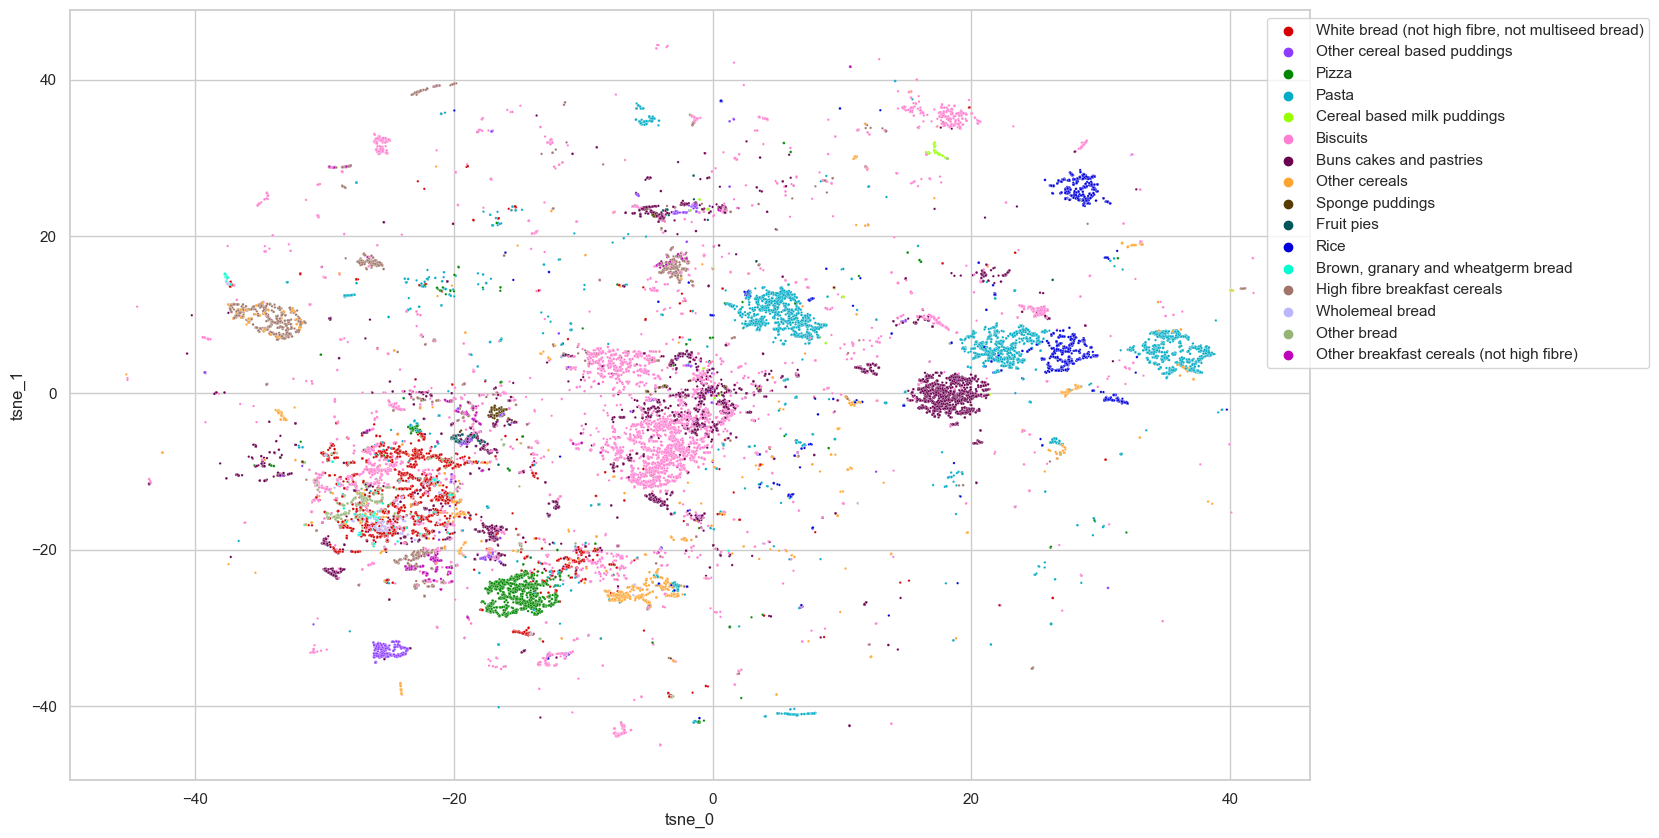

In [30]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pred['tsne_0'], y=pred['tsne_1'],
    hue=pred['subfoodgroup_pred'],
    palette=sns.color_palette(cc.glasbey, n_colors=pred['subfoodgroup_pred'].nunique()), s=3
)
plt.legend(bbox_to_anchor=(1.28, 1), loc='upper right')

In [31]:
# save level 2 cereal categories
pred.to_csv('../../future_of_food/NDNS UK/predictions/predictions_cereals_lev2_manuallabels_nonHI_RF_15Oct2024.csv', 
                      index=False)